In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

2024-02-21 11:20:40.093956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 11:20:40.094068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 11:20:40.185246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 11:20:40.377050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 11:20:42.056026: W tensorflow/compiler/tf2

In [7]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)

In [15]:


classifier = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_v2, input_shape=IMAGE_SHAPE+(3,))
])

In [12]:

grace_hopper = Image.open('WhatsApp Image 2024-02-07 at 6.49.28 PM.jpeg').resize(IMAGE_SHAPE)


In [13]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [16]:
predicted = classifier.predict(grace_hopper[np.newaxis, ...])
predicted.shape
predicted = np.argmax(predicted, axis=1)
predicted
imagenet_labels[predicted]

1/1 [==============================] - 0s 500ms/step


array(['Ibizan hound'], dtype='<U30')

In [2]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'archive/cropped/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 12000 files belonging to 120 classes.
Using 9600 files for training.


2024-02-21 11:20:47.992987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 11:20:48.313924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 11:20:48.314820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 12000 files belonging to 120 classes.
Using 2400 files for validation.


In [3]:
class_names = np.array(train_ds.class_names)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [9]:

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
     

In [10]:

result_batch = classifier.predict(train_ds)

2024-02-07 14:27:00.181335: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-07 14:27:00.533044: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


300/300 [==============================] - 61s 174ms/step


In [18]:

     

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names
     

300/300 [==============================] - 52s 174ms/step


array(['Chihuahua', 'golden retriever', 'Pomeranian', ..., 'clumber',
       'English foxhound', 'cairn'], dtype='<U30')

In [12]:
from tensorflow import keras

In [14]:
num_of_flowers = len(class_names)

model = tf.keras.Sequential([
      keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2411704 (9.20 MB)
Trainable params: 153720 (600.47 KB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [15]:

model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


Epoch 1/10


2024-02-07 14:29:16.555932: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f29727aa470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 14:29:16.555962: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-02-07 14:29:16.574401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/300 [..............................] - ETA: 22:39 - loss: 5.0143 - acc: 0.0000e+00

I0000 00:00:1707308957.594454    4082 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 81s 255ms/step - loss: 1.7039 - acc: 0.5810 - val_loss: 0.7315 - val_acc: 0.7650
Epoch 2/10
300/300 [==============================] - 77s 255ms/step - loss: 0.7770 - acc: 0.7686 - val_loss: 0.6384 - val_acc: 0.7837
Epoch 3/10
300/300 [==============================] - 77s 258ms/step - loss: 0.6419 - acc: 0.8047 - val_loss: 0.5640 - val_acc: 0.8117
Epoch 4/10
300/300 [==============================] - 77s 257ms/step - loss: 0.5499 - acc: 0.8294 - val_loss: 0.5533 - val_acc: 0.8171
Epoch 5/10
300/300 [==============================] - 77s 257ms/step - loss: 0.4887 - acc: 0.8479 - val_loss: 0.5653 - val_acc: 0.8092
Epoch 6/10
300/300 [==============================] - 77s 257ms/step - loss: 0.4348 - acc: 0.8629 - val_loss: 0.5612 - val_acc: 0.8096
Epoch 7/10
300/300 [==============================] - 77s 257ms/step - loss: 0.3908 - acc: 0.8760 - val_loss: 0.5651 - val_acc: 0.8133
Epoch 8/10
300/300 [==============================] - 77s 257ms/st

In [64]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
300/300 [==============================] - 77s 257ms/step - loss: 0.2896 - acc: 0.9099 - val_loss: 0.5459 - val_acc: 0.8204
Epoch 2/10
300/300 [==============================] - 77s 257ms/step - loss: 0.2714 - acc: 0.9134 - val_loss: 0.5705 - val_acc: 0.8050
Epoch 3/10
300/300 [==============================] - 77s 257ms/step - loss: 0.2591 - acc: 0.9161 - val_loss: 0.5774 - val_acc: 0.8142
Epoch 4/10
300/300 [==============================] - 77s 257ms/step - loss: 0.2450 - acc: 0.9242 - val_loss: 0.5996 - val_acc: 0.8050
Epoch 5/10
300/300 [==============================] - 77s 256ms/step - loss: 0.2370 - acc: 0.9235 - val_loss: 0.5799 - val_acc: 0.8112
Epoch 6/10
300/300 [==============================] - 77s 255ms/step - loss: 0.2081 - acc: 0.9352 - val_loss: 0.5991 - val_acc: 0.8104
Epoch 7/10
300/300 [==============================] - 77s 255ms/step - loss: 0.1987 - acc: 0.9384 - val_loss: 0.5814 - val_acc: 0.8108
Epoch 8/10
300/300 [==============================] - 7

In [19]:
predicted = model.predict(grace_hopper[np.newaxis, ...])
predicted.shape
predicted = np.argmax(predicted, axis=1)
class_names[predicted]

1/1 [==============================] - 3s 3s/step


array(['n02088238-basset'], dtype='<U40')

In [20]:
test_ds= tf.keras.utils.image_dataset_from_directory(
  'archive/cropped/test',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 8580 files belonging to 120 classes.


In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [21]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [22]:
model.evaluate(test_ds)


269/269 [==============================] - 55s 206ms/step - loss: 0.5655 - acc: 0.8244


[0.5654774308204651, 0.8243589997291565]

In [32]:
model.save('trans-model2')

INFO:tensorflow:Assets written to: transerModel1/assets


INFO:tensorflow:Assets written to: transerModel1/assets


In [1]:
from tensorflow.keras.models import load_model

2024-02-12 09:29:44.487178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 09:29:44.487481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 09:29:44.587246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 09:29:44.790381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 09:29:46.446412: W tensorflow/compiler/tf2

In [2]:
trans_model = load_model('trans-model2')

2024-02-12 09:29:48.231372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 09:29:48.592527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 09:29:48.593298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

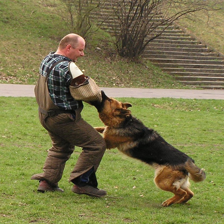

In [2]:


grace_hopper = Image.open('image-test/dog-1407425.jpg').resize((224, 224))
grace_hopper

In [18]:
# grace_hopper = np.array(grace_hopper)/255.0
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# array = grace_hopper[np.newaxis, ...]
# import json
# y = json.dumps(array.tolist(),separators=(',', ':'), 
#           sort_keys=True, 
#           indent=4)

# f = open("demofile3.txt", "w")
# f.write(y)
# f.close()

In [10]:
predicted = trans_model.predict(grace_hopper[np.newaxis, ...])
score = tf.nn.softmax(predicted[0])
print(100 * np.max(score))  
predicted = np.argmax(predicted, axis=1)
class_names[predicted][0]

1/1 [==============================] - 0s 34ms/step
76.72703266143799


'n02106662-German_shepherd'

In [4]:
predicted =[
        [
            -15.0176983,
            -23.716917,
            -19.9212265,
            -18.2458344,
            -20.3182983,
            -17.7943325,
            -19.365818,
            -19.386179,
            -19.5123806,
            -15.6936064,
            -12.9147778,
            -15.8824816,
            -18.9749985,
            -17.7468472,
            -19.5899906,
            -22.1196442,
            -20.3103027,
            -19.732996,
            -20.3553219,
            -18.6916237,
            -18.5538559,
            -10.5900278,
            -19.1635265,
            -15.4991198,
            -17.7905331,
            -16.9652138,
            -18.3990173,
            -12.7540512,
            -17.7611523,
            -16.8114376,
            -18.438446,
            -21.2645931,
            -18.7483139,
            -16.775898,
            -19.0467205,
            -17.4257126,
            -15.1703,
            -23.965704,
            -14.4795198,
            -21.1022243,
            -15.5586853,
            -22.0241776,
            -20.9757481,
            -20.9599609,
            -18.5905457,
            -16.5101585,
            -19.0791817,
            -20.5248756,
            -15.8457441,
            -23.1159935,
            -19.5043488,
            -18.4589367,
            -20.2652645,
            -15.9254303,
            -15.2509546,
            -16.0867214,
            -18.6742878,
            -15.2909956,
            -13.6281576,
            -17.8882885,
            -22.9862881,
            -17.6517372,
            -18.3116646,
            -21.4408588,
            -15.76373,
            -16.8298759,
            -18.1352177,
            -20.7763882,
            -17.6138592,
            -19.8908176,
            -17.4350204,
            -17.2336025,
            -19.4972305,
            -16.4610653,
            -19.3759365,
            -17.9063129,
            -20.5022526,
            -20.8341751,
            -22.2504654,
            -13.1208897,
            -18.2130623,
            -20.967432,
            -15.6065454,
            -18.5607033,
            -15.2745504,
            -15.5589952,
            -18.6413307,
            -18.6642036,
            -19.0675678,
            -20.3442135,
            -18.9284267,
            -18.1020508,
            -19.290287,
            -17.2064934,
            -15.4022284,
            -15.9818459,
            -19.8965645,
            -16.1818771,
            -14.9351673,
            -17.2677364,
            -17.5383072,
            -21.2984886,
            -16.9593697,
            -18.1001987,
            -11.1294708,
            -16.2670078,
            -15.5169096,
            -17.5762825,
            -14.6437283,
            -16.0503578,
            -19.5154305,
            -15.023262,
            -18.4703026,
            -15.9495687,
            -19.1358299,
            -15.3623514,
            -21.3906136,
            -22.0312538,
            -19.5920639,
            -12.2986107
        ]
    ]
score = tf.nn.softmax(predicted[0])
print(100 * np.max(score))  
predicted = np.argmax(predicted, axis=1)
class_names[predicted][0]

42.36522614955902


'n02091134-whippet'

INFO:tensorflow:Assets written to: trans-model2/assets


INFO:tensorflow:Assets written to: trans-model2/assets


In [69]:
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
  for i in range(8):
    predicted = model.predict((np.array(images[i]))[np.newaxis, ...])

    predicted = np.argmax(predicted, axis=1)
    actaul = class_names[labels[i]]
    pred =  class_names[predicted][0] 
    print(actaul +'--predicted:\n' + pred)
   

1/1 [==============================] - 0s 26ms/step
n02085620-Chihuahua--predicted:
n02085620-Chihuahua
1/1 [==============================] - 0s 22ms/step
n02092002-Scottish_deerhound--predicted:
n02092002-Scottish_deerhound
1/1 [==============================] - 0s 23ms/step
n02107683-Bernese_mountain_dog--predicted:
n02107683-Bernese_mountain_dog
1/1 [==============================] - 0s 25ms/step
n02092339-Weimaraner--predicted:
n02092339-Weimaraner
1/1 [==============================] - 0s 23ms/step
n02098413-Lhasa--predicted:
n02098413-Lhasa
1/1 [==============================] - 0s 23ms/step
n02101388-Brittany_spaniel--predicted:
n02101388-Brittany_spaniel
1/1 [==============================] - 0s 23ms/step
n02090622-borzoi--predicted:
n02090622-borzoi
1/1 [==============================] - 0s 21ms/step
n02096294-Australian_terrier--predicted:
n02096294-Australian_terrier


<Figure size 1000x500 with 0 Axes>